In [23]:
#!pip3 install datasets

In [24]:
#!pip3 install transformers -U;

In [25]:
#!pip3 install accelerate -U

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt

import torch
import tensorflow as tf

from sklearn.model_selection import train_test_split

import datasets
from datasets import Dataset, DatasetDict

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer

In [27]:
# !git clone https://github.com/cse151a-DrugReviewAnalysis/DrugReviewAnalysis.git

In [28]:
# Get dataset for working locally
df_train = pd.read_csv("drugsTrain_processed_with_usefulCount.csv", sep="\t")
df_test = pd.read_csv("drugsTest_processed_with_usefulCount.csv", sep="\t")

In [29]:
# Get dataset when working on colab
# df_train = pd.read_csv("DrugReviewAnalysis/Model 3/drugsTrain_processed_with_usefulCount.csv", sep="\t")
# df_test = pd.read_csv("DrugReviewAnalysis/Model 3/drugsTest_processed_with_usefulCount.csv", sep="\t")

In [30]:
df_train = df_train.sample(frac=0.7, random_state=42).reset_index()
df_test = df_test.sample(frac=0.7, random_state=42).reset_index()

In [31]:
df_train.shape, df_test.shape

((111649, 8), (37240, 8))

In [32]:
df_val, df_test_new = train_test_split(df_test, test_size=0.6, random_state=42)

In [33]:
ds_train = Dataset.from_pandas(df_train[["processed_review", "rating"]])
ds_val = Dataset.from_pandas(df_val.reset_index()[["processed_review", "rating"]])
ds_test = Dataset.from_pandas(df_test_new.reset_index()[["processed_review", "rating"]])

In [34]:
ds = DatasetDict()

ds["train"] = ds_train
ds["validation"] = ds_val
ds["test"] = ds_test

In [35]:
ds

DatasetDict({
    train: Dataset({
        features: ['processed_review', 'rating'],
        num_rows: 111649
    })
    validation: Dataset({
        features: ['processed_review', 'rating'],
        num_rows: 14896
    })
    test: Dataset({
        features: ['processed_review', 'rating'],
        num_rows: 22344
    })
})

In [36]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [37]:
def preprocess(samples):
  text = samples["processed_review"]
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128, return_attention_mask=True)
  encoding["labels"] = samples["rating"]
  return encoding

In [38]:
encoded_dataset = ds.map(preprocess, batched=True, remove_columns=ds['train'].column_names)

Map: 100%|██████████| 22344/22344 [00:02<00:00, 9180.08 examples/s]


In [39]:
encoded_dataset.set_format("torch")

In [40]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:

args = TrainingArguments(
    output_dir="/bert-regression", # for local
    # output_dir = "DrugReviewAnalysis/Model 3/bert-regression", # for colab
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
)

In [42]:
def compute_metrics(eval_pred):
  predictions, labels = eval_pred
  mse = mean_squared_error(labels, predictions)
  pred_modified = np.where(predictions < 10.0, np.round(predictions), 10.0)
  print(labels)
  acc = accuracy_score(labels, pred_modified)
  f1 = f1_score(labels, pred_modified, average="macro")
  return {"mse": mse, "accuracy-approximation": acc, "f1-approximation": f1}

In [43]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

c:\Users\jason\AppData\Local\Programs\Python\Python311\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [45]:
trainer.train()

  3%|▎         | 500/17450 [03:14<1:47:14,  2.63it/s]

{'loss': 2.905, 'grad_norm': 95.69025421142578, 'learning_rate': 1.9426934097421205e-05, 'epoch': 0.29}


  6%|▌         | 1000/17450 [06:28<1:44:39,  2.62it/s]

{'loss': 2.4893, 'grad_norm': 42.23804473876953, 'learning_rate': 1.8853868194842408e-05, 'epoch': 0.57}


  9%|▊         | 1500/17450 [09:40<1:40:36,  2.64it/s]

{'loss': 2.6165, 'grad_norm': 58.98017501831055, 'learning_rate': 1.828080229226361e-05, 'epoch': 0.86}


 10%|█         | 1745/17450 [11:14<1:25:33,  3.06it/s]

[ 1.  1.  8. ...  1. 10.  4.]


                                                      
 10%|█         | 1745/17450 [11:47<1:25:33,  3.06it/s]Checkpoint destination directory /bert-regression\checkpoint-1745 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.60516357421875, 'eval_mse': 2.60516357421875, 'eval_accuracy-approximation': 0.3788265306122449, 'eval_f1-approximation': 0.2734060404839417, 'eval_runtime': 32.098, 'eval_samples_per_second': 464.079, 'eval_steps_per_second': 7.259, 'epoch': 1.0}


 11%|█▏        | 2000/17450 [13:28<1:37:50,  2.63it/s] 

{'loss': 2.4085, 'grad_norm': 22.057466506958008, 'learning_rate': 1.7707736389684814e-05, 'epoch': 1.15}


 14%|█▍        | 2500/17450 [16:39<1:34:31,  2.64it/s]

{'loss': 1.9956, 'grad_norm': 35.471858978271484, 'learning_rate': 1.7134670487106017e-05, 'epoch': 1.43}


 17%|█▋        | 3000/17450 [19:50<1:31:14,  2.64it/s]

{'loss': 1.9279, 'grad_norm': 29.316661834716797, 'learning_rate': 1.6561604584527223e-05, 'epoch': 1.72}


 20%|██        | 3490/17450 [22:55<1:16:03,  3.06it/s]

[ 1.  1.  8. ...  1. 10.  4.]


                                                      
 20%|██        | 3490/17450 [23:27<1:16:03,  3.06it/s]Checkpoint destination directory /bert-regression\checkpoint-3490 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.3963122367858887, 'eval_mse': 2.3963122367858887, 'eval_accuracy-approximation': 0.41803168635875404, 'eval_f1-approximation': 0.3043177702084166, 'eval_runtime': 31.8835, 'eval_samples_per_second': 467.201, 'eval_steps_per_second': 7.308, 'epoch': 2.0}


 20%|██        | 3500/17450 [23:35<3:23:22,  1.14it/s] 

{'loss': 1.8753, 'grad_norm': 26.11258888244629, 'learning_rate': 1.5988538681948423e-05, 'epoch': 2.01}


 23%|██▎       | 4000/17450 [26:46<1:25:13,  2.63it/s]

{'loss': 1.4689, 'grad_norm': 90.81471252441406, 'learning_rate': 1.541547277936963e-05, 'epoch': 2.29}


 26%|██▌       | 4500/17450 [29:53<1:13:41,  2.93it/s]

{'loss': 1.4461, 'grad_norm': 31.236661911010742, 'learning_rate': 1.4842406876790831e-05, 'epoch': 2.58}


 29%|██▊       | 5000/17450 [32:45<1:11:55,  2.89it/s]

{'loss': 1.4396, 'grad_norm': 38.286285400390625, 'learning_rate': 1.4269340974212036e-05, 'epoch': 2.87}


 30%|███       | 5235/17450 [34:06<1:00:54,  3.34it/s]

[ 1.  1.  8. ...  1. 10.  4.]


                                                      
 30%|███       | 5235/17450 [34:35<1:00:54,  3.34it/s]Checkpoint destination directory /bert-regression\checkpoint-5235 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.350306749343872, 'eval_mse': 2.350306510925293, 'eval_accuracy-approximation': 0.4321965628356606, 'eval_f1-approximation': 0.31110733775704946, 'eval_runtime': 28.9271, 'eval_samples_per_second': 514.949, 'eval_steps_per_second': 8.055, 'epoch': 3.0}


 32%|███▏      | 5500/17450 [36:10<1:07:16,  2.96it/s] 

{'loss': 1.3099, 'grad_norm': 22.634063720703125, 'learning_rate': 1.3696275071633239e-05, 'epoch': 3.15}


 34%|███▍      | 6000/17450 [39:10<1:17:04,  2.48it/s]

{'loss': 1.1265, 'grad_norm': 20.024658203125, 'learning_rate': 1.3123209169054444e-05, 'epoch': 3.44}


 37%|███▋      | 6500/17450 [42:55<1:35:59,  1.90it/s]

{'loss': 1.1221, 'grad_norm': 19.483234405517578, 'learning_rate': 1.2550143266475645e-05, 'epoch': 3.72}


 40%|████      | 6980/17450 [46:01<50:57,  3.42it/s]  

[ 1.  1.  8. ...  1. 10.  4.]


                                                    
 40%|████      | 6980/17450 [46:29<50:57,  3.42it/s]Checkpoint destination directory /bert-regression\checkpoint-6980 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.247688055038452, 'eval_mse': 2.247688055038452, 'eval_accuracy-approximation': 0.45233619763694954, 'eval_f1-approximation': 0.3369046253922941, 'eval_runtime': 28.3212, 'eval_samples_per_second': 525.966, 'eval_steps_per_second': 8.227, 'epoch': 4.0}


 40%|████      | 7000/17450 [46:39<1:00:20,  2.89it/s] 

{'loss': 1.1011, 'grad_norm': 12.612014770507812, 'learning_rate': 1.197707736389685e-05, 'epoch': 4.01}


 43%|████▎     | 7500/17450 [49:29<56:40,  2.93it/s]  

{'loss': 0.932, 'grad_norm': 32.902801513671875, 'learning_rate': 1.1404011461318051e-05, 'epoch': 4.3}


 46%|████▌     | 8000/17450 [52:22<57:14,  2.75it/s]  

{'loss': 0.9162, 'grad_norm': 22.089685440063477, 'learning_rate': 1.0830945558739256e-05, 'epoch': 4.58}


 49%|████▊     | 8500/17450 [55:27<53:52,  2.77it/s]  

{'loss': 0.9101, 'grad_norm': 38.41679382324219, 'learning_rate': 1.0257879656160459e-05, 'epoch': 4.87}


 50%|█████     | 8725/17450 [56:50<46:42,  3.11it/s]  

[ 1.  1.  8. ...  1. 10.  4.]


                                                    
 50%|█████     | 8725/17450 [57:23<46:42,  3.11it/s]Checkpoint destination directory /bert-regression\checkpoint-8725 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.1937434673309326, 'eval_mse': 2.1937434673309326, 'eval_accuracy-approximation': 0.4714017185821697, 'eval_f1-approximation': 0.35248618265194975, 'eval_runtime': 32.9473, 'eval_samples_per_second': 452.116, 'eval_steps_per_second': 7.072, 'epoch': 5.0}


 52%|█████▏    | 9000/17450 [59:57<1:19:57,  1.76it/s] 

{'loss': 0.8038, 'grad_norm': 14.267265319824219, 'learning_rate': 9.684813753581662e-06, 'epoch': 5.16}


 54%|█████▍    | 9500/17450 [1:06:20<2:25:20,  1.10s/it]

{'loss': 0.7714, 'grad_norm': 22.769817352294922, 'learning_rate': 9.111747851002865e-06, 'epoch': 5.44}


 57%|█████▋    | 10000/17450 [1:13:41<2:59:03,  1.44s/it]

{'loss': 0.7696, 'grad_norm': 19.873868942260742, 'learning_rate': 8.53868194842407e-06, 'epoch': 5.73}


                                                         
 60%|██████    | 10470/17450 [1:19:48<56:33,  2.06it/s]

[ 1.  1.  8. ...  1. 10.  4.]
{'eval_loss': 2.1464502811431885, 'eval_mse': 2.1464502811431885, 'eval_accuracy-approximation': 0.5001342642320086, 'eval_f1-approximation': 0.37400376038446703, 'eval_runtime': 47.2436, 'eval_samples_per_second': 315.302, 'eval_steps_per_second': 4.932, 'epoch': 6.0}


 60%|██████    | 10500/17450 [1:20:07<1:05:49,  1.76it/s] 

{'loss': 0.737, 'grad_norm': 23.558486938476562, 'learning_rate': 7.965616045845273e-06, 'epoch': 6.02}


 63%|██████▎   | 11000/17450 [1:24:59<1:02:58,  1.71it/s]

{'loss': 0.6628, 'grad_norm': 25.856847763061523, 'learning_rate': 7.392550143266476e-06, 'epoch': 6.3}


 66%|██████▌   | 11500/17450 [1:29:48<54:23,  1.82it/s]  

{'loss': 0.6325, 'grad_norm': 15.768644332885742, 'learning_rate': 6.819484240687679e-06, 'epoch': 6.59}


 69%|██████▉   | 12000/17450 [1:34:23<52:57,  1.72it/s]

{'loss': 0.6333, 'grad_norm': 13.51729679107666, 'learning_rate': 6.246418338108883e-06, 'epoch': 6.88}


 70%|███████   | 12215/17450 [1:36:24<41:47,  2.09it/s]

[ 1.  1.  8. ...  1. 10.  4.]


                                                       
 70%|███████   | 12215/17450 [1:37:11<41:47,  2.09it/s]

{'eval_loss': 2.0931339263916016, 'eval_mse': 2.0931339263916016, 'eval_accuracy-approximation': 0.5056390977443609, 'eval_f1-approximation': 0.3904836707766589, 'eval_runtime': 46.363, 'eval_samples_per_second': 321.29, 'eval_steps_per_second': 5.026, 'epoch': 7.0}


 72%|███████▏  | 12500/17450 [1:39:49<43:16,  1.91it/s]   

{'loss': 0.5923, 'grad_norm': 10.888526916503906, 'learning_rate': 5.673352435530086e-06, 'epoch': 7.16}


 74%|███████▍  | 13000/17450 [1:44:20<41:40,  1.78it/s]

{'loss': 0.5648, 'grad_norm': 22.482486724853516, 'learning_rate': 5.10028653295129e-06, 'epoch': 7.45}


 77%|███████▋  | 13500/17450 [1:48:48<38:58,  1.69it/s]

{'loss': 0.553, 'grad_norm': 20.177427291870117, 'learning_rate': 4.527220630372493e-06, 'epoch': 7.74}


                                                       
 80%|████████  | 13960/17450 [1:53:44<27:24,  2.12it/s]

[ 1.  1.  8. ...  1. 10.  4.]
{'eval_loss': 2.0610203742980957, 'eval_mse': 2.0610203742980957, 'eval_accuracy-approximation': 0.514030612244898, 'eval_f1-approximation': 0.4036513857627835, 'eval_runtime': 43.5994, 'eval_samples_per_second': 341.656, 'eval_steps_per_second': 5.344, 'epoch': 8.0}


 80%|████████  | 14000/17450 [1:54:08<31:15,  1.84it/s]   

{'loss': 0.5479, 'grad_norm': 20.669883728027344, 'learning_rate': 3.954154727793696e-06, 'epoch': 8.02}


 83%|████████▎ | 14500/17450 [1:58:29<23:16,  2.11it/s]

{'loss': 0.4972, 'grad_norm': 9.329983711242676, 'learning_rate': 3.3810888252149e-06, 'epoch': 8.31}


 86%|████████▌ | 15000/17450 [2:02:48<20:12,  2.02it/s]

{'loss': 0.4998, 'grad_norm': 18.9431095123291, 'learning_rate': 2.8080229226361035e-06, 'epoch': 8.6}


 89%|████████▉ | 15500/17450 [2:06:57<15:52,  2.05it/s]

{'loss': 0.4922, 'grad_norm': 17.21569061279297, 'learning_rate': 2.2349570200573066e-06, 'epoch': 8.88}


                                                       
 90%|█████████ | 15705/17450 [2:09:19<12:04,  2.41it/s]

[ 1.  1.  8. ...  1. 10.  4.]
{'eval_loss': 2.0375728607177734, 'eval_mse': 2.0375728607177734, 'eval_accuracy-approximation': 0.5198711063372717, 'eval_f1-approximation': 0.41003823655054716, 'eval_runtime': 41.7714, 'eval_samples_per_second': 356.608, 'eval_steps_per_second': 5.578, 'epoch': 9.0}


 92%|█████████▏| 16000/17450 [2:11:51<11:15,  2.15it/s]  

{'loss': 0.467, 'grad_norm': 12.808438301086426, 'learning_rate': 1.66189111747851e-06, 'epoch': 9.17}


 95%|█████████▍| 16500/17450 [2:15:55<08:02,  1.97it/s]

{'loss': 0.4555, 'grad_norm': 18.319612503051758, 'learning_rate': 1.0888252148997136e-06, 'epoch': 9.46}


 97%|█████████▋| 17000/17450 [2:20:50<02:33,  2.93it/s]

{'loss': 0.4517, 'grad_norm': 10.570630073547363, 'learning_rate': 5.15759312320917e-07, 'epoch': 9.74}


100%|██████████| 17450/17450 [2:23:45<00:00,  2.22it/s]

[ 1.  1.  8. ...  1. 10.  4.]


                                                       
100%|██████████| 17450/17450 [2:24:34<00:00,  2.22it/s]

{'eval_loss': 2.0344936847686768, 'eval_mse': 2.0344936847686768, 'eval_accuracy-approximation': 0.5216836734693877, 'eval_f1-approximation': 0.4117950012247834, 'eval_runtime': 48.6908, 'eval_samples_per_second': 305.93, 'eval_steps_per_second': 4.785, 'epoch': 10.0}


100%|██████████| 17450/17450 [2:24:38<00:00,  2.01it/s]

{'train_runtime': 8678.049, 'train_samples_per_second': 128.657, 'train_steps_per_second': 2.011, 'train_loss': 1.1042376805171583, 'epoch': 10.0}


TrainOutput(global_step=17450, training_loss=1.1042376805171583, metrics={'train_runtime': 8678.049, 'train_samples_per_second': 128.657, 'train_steps_per_second': 2.011, 'train_loss': 1.1042376805171583, 'epoch': 10.0})

In [47]:
training_log = pd.DataFrame(trainer.state.log_history)
training_log.head()

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_mse,eval_accuracy-approximation,eval_f1-approximation,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,2.9050,95.690254,0.000019,0.29,500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.4893,42.238045,0.000019,0.57,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.6165,58.980175,0.000018,0.86,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,1.00,1745,2.605164,2.605164,0.378827,0.273406,32.098,464.079,7.259,NaN,NaN,NaN,NaN,NaN
4,2.4085,22.057467,0.000018,1.15,2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


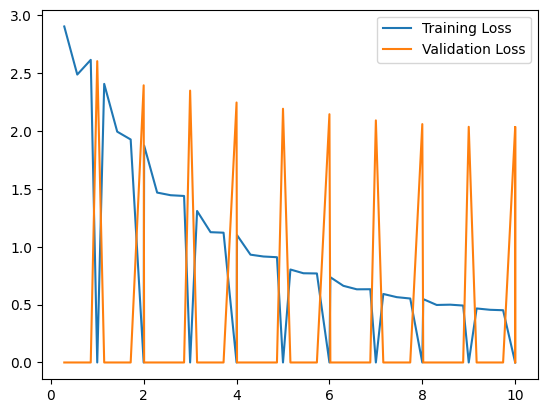

In [48]:
plt.plot(training_log["epoch"], training_log["loss"].fillna(0), label="Training Loss")
plt.plot(training_log["epoch"], training_log["eval_loss"].fillna(0), label="Validation Loss")

plt.legend(loc="best")
plt.show()

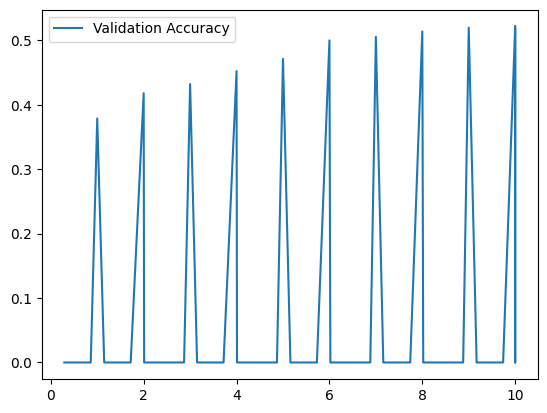

In [49]:
plt.plot(training_log["epoch"], training_log["eval_accuracy-approximation"].fillna(0), label="Validation Accuracy")
plt.legend(loc="best")
plt.show()

In [46]:
trainer.evaluate()

100%|██████████| 233/233 [00:50<00:00,  4.88it/s]

[ 1.  1.  8. ...  1. 10.  4.]


100%|██████████| 233/233 [00:51<00:00,  4.56it/s]


{'eval_loss': 2.0344936847686768,
 'eval_mse': 2.0344936847686768,
 'eval_accuracy-approximation': 0.5216836734693877,
 'eval_f1-approximation': 0.4117950012247834,
 'eval_runtime': 53.1525,
 'eval_samples_per_second': 280.25,
 'eval_steps_per_second': 4.384,
 'epoch': 10.0}

In [ ]:
# local
trainer.save_model("./bert-regression") 

# colab
# trainer.save_model("DrugReviewAnalysis/Model 3/bert-regression")

In [ ]:
# local
# model = AutoModelForSequenceClassification.from_pretrained("bert-regression")

# colab
# model = AutoModelForSequenceClassification.from_pretrained("DrugReviewAnalysis/Model 3/bert-regression")

# trainer = Trainer(
#     model=model,
#     args=args,
#     train_dataset=encoded_dataset["train"],
#     eval_dataset=encoded_dataset["validation"],
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics
# )

In [51]:
trainer.evaluate(eval_dataset=encoded_dataset["test"])

401it [01:27,  3.59it/s]                         

[10.  1.  1. ...  7.  6.  7.]


402it [01:27,  4.59it/s]


{'eval_loss': 2.011652708053589,
 'eval_mse': 2.011652708053589,
 'eval_accuracy-approximation': 0.5224668814894379,
 'eval_f1-approximation': 0.4118035198430426,
 'eval_runtime': 76.9358,
 'eval_samples_per_second': 290.424,
 'eval_steps_per_second': 4.549,
 'epoch': 10.0}